In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

from sklearn.model_selection import train_test_split

import numpy as np

from math import pow, floor

import matplotlib.pyplot as plt

import os.path
import os

from pathlib import Path

In [2]:
# this is required for matplotlib to work correctly within jupyter
%matplotlib inline

In [3]:
# config
# directory with data
DATA_DIR = "./dataset2/"

# image dimensions
IMG_WIDTH = 175
IMG_HEIGHT = 70

# size of the batch for training
BATCH_SIZE = 70

In [17]:
# loading data
data_dir = Path(DATA_DIR)

# creates list of paths to images in dataset and their corresponding labels 
images = list(map(str, list(data_dir.glob("*.png"))))
labels = [str(img).split(os.path.sep)[1].split(".")[0][:4] for img in images]
labels = list(map(str.lower, labels))

# finds all unique characters used in labels
characters = sorted(set([char for label in labels for char in label]))
# finds the max length of labels
MAX_LENGTH = max(map(len, labels))

In [5]:
# train, validation split
# data is split in ratio of 95 % train data and 5 % validation data
train_images, valid_images, train_labels, valid_labels = train_test_split(np.array(images),np.array(labels), test_size=0.05)

In [6]:
# encodes characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters))

# decodes integers back to characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

def encode_single_sample(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [7]:
# creates 2 encoded dataset objects for faster computations

# train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# validation dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_dataset = (
    valid_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

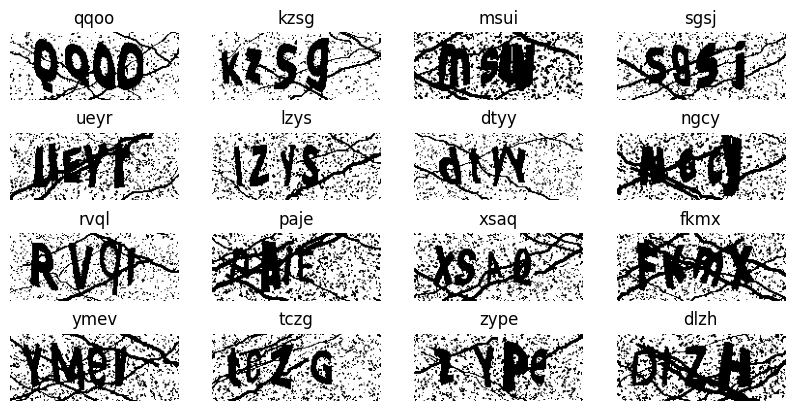

In [9]:
# visualization of validation dataset
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in valid_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [10]:
# Model topology 

# CTC loss function
class CTCLayer(layers.Layer):
    
    # custom ctc loss function
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # compute the training-time loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(tf.keras.backend.sum(loss))

        # At test time, just return the computed predictions
        return y_pred

# size of regulation use for l2 regularizer
regul_size = 0.0001

# definition of a residual block which returns the differnce between layer x and layer y
def residual_block(x, filters, kernel_size):
    y = layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal",padding="same", use_bias=False, kernel_regularizer=l2(regul_size))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    
    y = layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal",padding="same", use_bias=False, kernel_regularizer=l2(regul_size))(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    
    layer = layers.Add()([x, y])
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)
    
    return layer
    
# function which creates the model    
def build_model():
    
    # input layers
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    # CNN SEGMENT
    # first convolutional block
    x = layers.BatchNormalization()(input_img)
    x = layers.Conv2D(32, (3, 3), kernel_initializer="he_normal",padding="same",name="Conv1", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = residual_block(x, 32, (3,3))
    x = residual_block(x, 32, (3,3))

    # second convolutional block
    x = layers.Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv2", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = residual_block(x, 64, (3,3))
    x = residual_block(x, 64, (3,3))
    
    # third convolutional block
    x = layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv3", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    x = residual_block(x, 128, (3,3))
    x = residual_block(x, 128, (3,3))

    # first convolutional block
    x = layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding="same", name="Conv4", kernel_regularizer=l2(regul_size), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
        
    x = residual_block(x, 256, (3,3))
    x = residual_block(x, 256, (3,3))
    
    # data must be reshaped accordingly - 3x max pooling with a stride of 2
    # size of the image is divided by 8 and multiplied by the number of filters in last layer - 256
    new_shape = ((IMG_WIDTH // 8), (IMG_HEIGHT // 8) * 256)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    # simple dense layer for better stability
    x = layers.Dense(64, activation="relu", name="dense3")(x)

    # RNN SEGMENT
    
    # swo bidirectional Long-Short Term Memory layers are used to decode the characters taking order into consideration
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # output layer - output size is number of characters + 1
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)
    
    # custom ctc loss function is added in form of a layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    # model definition
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    
    # optimizer
    opt = keras.optimizers.Adam()
    
    # model compilation
    model.compile(optimizer=opt)
    
    return model

In [11]:
# Training

# Number of epoch per training
epochs = 20

# Training stops after 2 epochs if the validation accuracy is not improved
early_stopping_patience = 2

# add early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# variable learning rate - learning rate drops by half every two epochs
def step_decay(epoch):
    initial_lr = 0.005
    drop = 0.5
    epochs = 2
    lr_rate = initial_lr * pow(drop,  
           floor((1+epoch)/epochs))
    return lr_rate

lr_rate = LearningRateScheduler(step_decay)

# build and summarize the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 175, 70, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 175, 70, 1)  4           ['image[0][0]']                  
 alization)                                                                                       
                                                                                                  
 Conv1 (Conv2D)                 (None, 175, 70, 32)  288         ['batch_normalization[0][0]']    
                                                                                       

 add_2 (Add)                    (None, 87, 35, 64)   0           ['re_lu_7[0][0]',                
                                                                  're_lu_9[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 87, 35, 64)  256         ['add_2[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 re_lu_10 (ReLU)                (None, 87, 35, 64)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 87, 35, 64)   36864       ['re_lu_10[0][0]']               
                                                                                                  
 batch_nor

 Conv4 (Conv2D)                 (None, 43, 17, 256)  294912      ['re_lu_20[0][0]']               
                                                                                                  
 batch_normalization_22 (BatchN  (None, 43, 17, 256)  1024       ['Conv4[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 re_lu_21 (ReLU)                (None, 43, 17, 256)  0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 pool3 (MaxPooling2D)           (None, 21, 8, 256)   0           ['re_lu_21[0][0]']               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 21, 8, 256)   589824      ['pool3[0][0]']                  
          

In [ ]:
# train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_rate],
)

In [44]:
# save model
model.save("models/loss")

INFO:tensorflow:Assets written to: models/loss_27_3_success_96_8\assets


INFO:tensorflow:Assets written to: models/loss_27_3_success_96_8\assets


In [12]:
# load model
model = keras.models.load_model("models/loss_27_3_success_96_8/")

In [13]:
# creates list of paths to images in dataset and their corresponding labels 
ULOZTO_DIR = "./original_captcha/bw/"
data_dir = Path(ULOZTO_DIR)
ulozto_images = list(map(str, list(data_dir.glob("*.png"))))
ulozto_labels = [str(img).split(os.path.sep)[2].split(".")[0] for img in ulozto_images]

# creates dataset object from ulozto original images for final validation
ulozto_dataset = tf.data.Dataset.from_tensor_slices((ulozto_images, ulozto_labels))
ulozto_dataset = (
    ulozto_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

tf.Tensor(
[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [0.]
   ...
   [1.]
   [0.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [1.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0

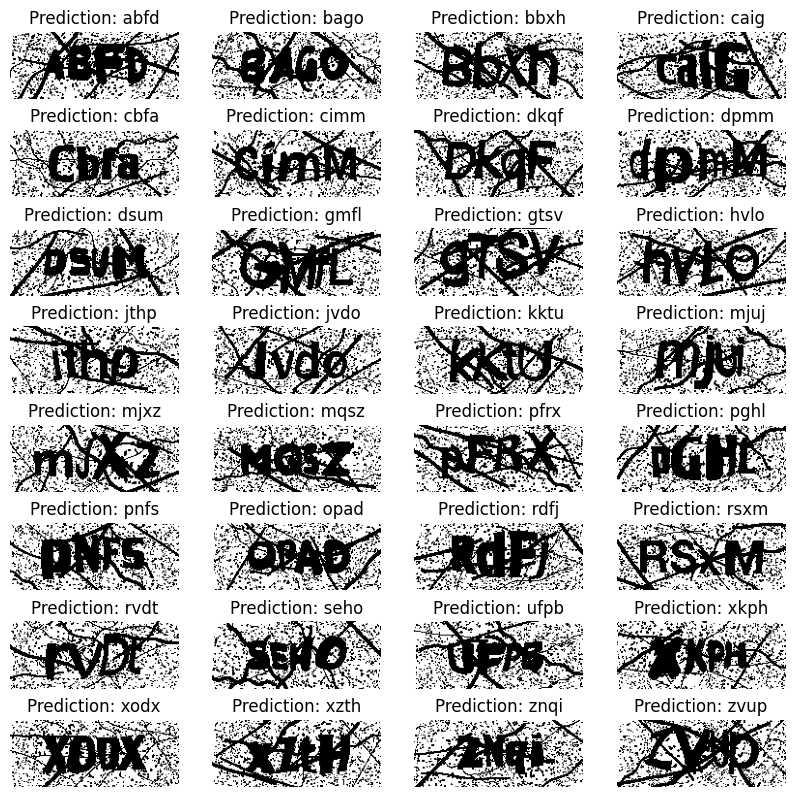

In [15]:
# gets prediction model
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)

# decodes the predictions
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :MAX_LENGTH]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


# visualization of the result
for batch in ulozto_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    print(batch_images)
    preds = prediction_model.predict(batch_images)
    print(preds)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
        
    _, ax = plt.subplots(8, 4, figsize=(10, 10))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Records

## Dataset2 - 314 269
**Success rate:** 62,5 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 3
## Dataset2 - 413 467
**Success rate:** 51,5 % (16 original test samples)<br>
**100 %** - 1<br>
**75 %** - 5
## Dataset2 - 413 467 (5th conv added, filters adjusted)
**Success rate:** 71,8 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 5
## Dataset2 - 413 467 (regul_size = 0.0001)
**Success rate:** 68,8 % (16 original test samples)<br>
**100 %** - 4<br>
**75 %** - 6
## Dataset2 - 413 467 (regul_size = 0)
**Success rate:** 70,3 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 5
## Dataset2 - 413 467 (residual blocks added (8))
**Success rate:** 71,8 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 7
## Dataset2 - 566 097 
**Success rate:** 75 % (16 original test samples)<br>
**100 %** - 5<br>
**75 %** - 8
## Dataset2 - 666 097 
**Success rate:** 67,2 % (16 original test samples)<br>
**100 %** - 4<br>
**75 %** - 5
## Dataset2 - 666 097 
**Success rate:** 73,4 % (32 original test samples)<br>
**100 %** - 11<br>
**75 %** - 10
## Dataset2 - 573 237 (regul_size = 0.0001)
**Success rate:** 85,1 % (32 original test samples)<br>
**100 %** - 17<br>
**75 %** - 12
## Dataset2 - 580 237 (regul_size = 0.0001)
**Success rate:** 95,3 % (32 original test samples)<br>
**100 %** - 26 <br>
**75 %** - 6
## Dataset2 - 592 882 (regul_size = 0.0001)
**Success rate:** 96,8 % (32 original test samples)<br>
**100 %** - 28 <br>
**75 %** - 4